<img src="https://www.th-koeln.de/img/logo.svg" style="float: right;" width="200" alt="Th-Köln-Logo">

# DIS21a 1 | Big Data | Exam WS 2022/23 | Group J (10)

## Participants

-   [Markus Hardtke](https://elearning.iws.th-koeln.de/moodle/user/profile.php?id=2705)
    -   Matriculation Number: 11141419
-   [Furkan Erdogan](https://elearning.iws.th-koeln.de/moodle/user/profile.php?id=2688)
    -   Matriculation Number: 11136112
-   [Jannik Loose](https://elearning.iws.th-koeln.de/moodle/user/profile.php?id=2687)
    -   Matriculation Number: 11140624
-   [Gilles Romer](https://elearning.iws.th-koeln.de/moodle/user/profile.php?id=2681)
    -   Matriculation Number: 11139919

---

## Project Setup

*This Setup was made for Windows users and will differ if you are using a different OS.    
The recommended Python version used to run this notebook is 3.9.13*

1. Virtual environment

    *This step is required so you can install the required packages without affecting or filling up your global Python installation.*

    ```bash
    python3 -m venv .venv
    source .venv/Scripts/activate
    pip install -r requirements.txt
    ```

2. Git

    *This step is required so unnecessary data from the Notebook is not pushed to the repository. This will automatically remove all metadata and execution counts from the Notebook as soon as you stage your file.*

    1. Download JQ (flexible command-line JSON processor) from [here](https://github.com/stedolan/jq/releases/download/jq-1.6/jq-win64.exe)
    2. Create the following Folder: `C:\Program Files\jq`
    3. Add the following line to your PATH environment variable: `C:\Program Files\jq`
    4. Rename the downloaded JQ file to `jq.exe` and move it to the previously created folder
    5. Add the following lines to your .gitconfig file (usually found in C:\Users\YOUR_USERNAME\.gitconfig)

        ```bash
        [core]
            attributesfile = ~/.gitattributes_global
        [filter "nbstrip_meta"]
            clean = "jq --indent 4 \
                    '(.cells[] | select(has(\"execution_count\")) | .execution_count) = null  \
                    | .metadata = {\"language_info\": {\"name\": \"python\", \"pygments_lexer\": \"ipython3\"}} \
                    | .cells[].metadata = {} \
                    '"
            smudge = cat
            required = true
        [filter "nbstrip_full"]
            clean = "jq --indent 4 \
                    '(.cells[] | select(has(\"outputs\")) | .outputs) = []  \
                    | (.cells[] | select(has(\"execution_count\")) | .execution_count) = null  \
                    | .metadata = {\"language_info\": {\"name\": \"python\", \"pygments_lexer\": \"ipython3\"}} \
                    | .cells[].metadata = {} \
                    '"
            smudge = cat
            required = true
        ```

    6. Create a `.gitattributes_global` file at the same location as your `.gitconfig` file and add the following lines:

        ```bash
        *.ipynb filter=nbstrip_meta
        ```

3. Weights and Biases

    *Weights and Biases is a tool that helps you track your experiments and visualize your results. It is also used to run hyperparameter sweeps.*  
    
    Make sure to create an account on [Weights and Biases](https://wandb.ai/site) and accept the invitation to the Team.  
    Furthermore you will have to add your [API key](https://wandb.ai/settings#dangerzone) to the [scrts.py](./scrts.py) file under `wandb_api_key`.

## Optional Setup

1. Tensorflow GPU support  

    *<span style="color:orange">This step is optional and only required if you want to use a GPU for training.</span>*  
   Follow this setup to activate tensorflow GPU support (Make sure to install the mentioned versions rather than the latest one!): [https://www.tensorflow.org/install/gpu](https://www.tensorflow.org/install/gpu)  
   This tutorial will additionally help you to install CUDA and cuDNN: [https://lifewithdata.com/2022/01/16/how-to-install-tensorflow-and-keras-with-gpu-support-on-windows/](https://lifewithdata.com/2022/01/16/how-to-install-tensorflow-and-keras-with-gpu-support-on-windows/) 

---


## Objective

The aim of this kernel is to predict <span style="color:orange">partitions of images of different environments</span> from the dataset `environments` which are `{streets, sea, mountain, glacier, forest, buildings}`. We developed a classifier that distinguishes the images in the best possible way. The biggest challenge is to get the most accuracy with using our own image classification algorithm `categorical_classification` and trying out `ResNET` as an another image classification algorithm.

---
## Environment Setup

### Path's

We're importing libraries `os` and `sys`. 
The os and sys modules provide numerous tools for dealing with file names, paths and directories. We're setting up the path to the root of our repository.


In [ ]:
# Importing the necessary libraries
import os
import sys

# Setting up the path to the root of the repository
path = os.getcwd()
notebookpath = os.path.join(path, 'Exam_WS2223.ipynb')

datapath = os.path.join(path, 'data')
data_testpath = os.path.join(datapath, 'seg_test')
data_trainpath = os.path.join(datapath, 'seg_train')
data_valpath = os.path.join(datapath, 'seg_pred')

---
### Tensorflow version and GPU availability

We're importing here important and necessary libraries. Then we're checking with the code the versions and gpu availability to set up the GPU if it was installed in the section above. This code then will tell if the GPU is available or not in case if one should have overlooked a step.

---

As mentioned earlier, this section is dedicated to the optional scenario of using the GPU. The code provides information about whether a GPU is used and other information about the GPU. It also includes the Tensorflow/Keras libraries for use and shows the versions of these libraries.

In [ ]:
# Importing the libraries
import tensorflow as tf
from tensorflow import keras
import gc

# Checking versions and gpu availability
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# Setting up the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


Tensorflow version: 2.10.0
Keras Version: 2.10.0
GPU is available
1 Physical GPUs, 1 Logical GPUs


---
### Wandb

Here we import more important libraries to remove unnecessary logs later.  
**WandbMetricsLogger**: Used for Experiment Tracking.  
**WandbModelCheckpoints**: Used to log the model checkpoints to Weight and Biases Artifacts.

In [ ]:
# Importing the libraries
import wandb
import scrts
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import logging
import absl.logging
import os

# Removing all unnecessary logs
absl.logging.set_verbosity(absl.logging.ERROR)
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
os.environ['WANDB_SILENT'] = 'true'
os.environ['WANDB_CONSOLE'] = 'off'
os.environ['WANDB_NOTEBOOK_NAME'] = notebookpath
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

if scrts.wandb_api_key is None:
    print("Please enter your wandb API key in scrts.py")
else:
    wandb.login(key=scrts.wandb_api_key)

---
## Helper functions

### Plotting the loss and accuracy
We visualise the images via [seaborn](https://seaborn.pydata.org/) and [matplotlib](https://matplotlib.org/), which are afterwards split into data and labels with a defined function. 

### Data loading and preprocessing

This code defines a list of classes and a function called `load_data`. The function loads and preprocesses images from a **"seg_train"** and **"seg_test"** directory within the provided file path. The images are resized to 150x150 and appended to a data list along with their matched folder (label). The data is then shuffled and split into images and labels for both the training and test sets. The result of the function are returned as images with labels.



### Data Augmentation
The following function applies data augmentation to the training images using the `ImageDataGenerator` class from the *TensorFlow  library*, such as random rotation or shifts, etc.. to increase the diversity of the training data. The function returns two generators, one for the training set and one for the test set, which can be used to feed images to a model during training and evaluation.

### Label vectorization and image normalization
Here we're vectorizing the labels and doing an [One-hot encoding the labels](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical). One-Hot Encoding is a popular technique for treating categorical variables. It simply creates additional features based on the number of unique values in the categorical feature. Every unique value in the category will be added as a feature.

This part defines two functions, `label_vectorization` and `image_normalization`, these are used to preprocess data for machine learning. The `label_vectorization` function converts text labels to numerical labels and the `image_normalization` function converts images to arrays and normalizes them by dividing all pixel values by 255. These functions to prepare the data for the later use in the neural network model.



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting the loss and accuracy of the model
def plot_loss_accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(history.history["loss"], label="Training loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(history.history["accuracy"], label="Training accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation accuracy")
    plt.legend()
    plt.show()

# Data loading and preprocessing (... a bit)
import random
import numpy as np
classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

from PIL import Image
from PIL.ExifTags import TAGS
def load_data(datapath, classes):
    # Only load training and test data
    for dataset in os.listdir(datapath):
        if dataset == "seg_train" or dataset == "seg_test":
            # Load the data
            data = []
            for folder in os.listdir(os.path.join(datapath, dataset)):
                for image in os.listdir(os.path.join(datapath, dataset, folder)):
                    # resize images to 150x150
                    img = Image.open(os.path.join(datapath, dataset, folder, image))
                    img = img.resize((150, 150))
                    data.append([img, folder])
            # Shuffle the data
            random.shuffle(data)
            # Split the images into data(the actual image) and labels
            images = []
            labels = []
            for image in data:
                images.append(image[0])
                labels.append(image[1])
            if dataset == "seg_train":
                train_images = images
                train_labels = labels
            else:
                test_images = images
                test_labels = labels
    return train_images, train_labels, test_images, test_labels

# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def augment_data(datapath, classes, train_dir=data_trainpath, test_dir=data_testpath):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')
    return train_generator, test_generator

# Vectorizing the labels
def label_vectorization(labels):
    # Convert the labels to numbers
    for i, label in enumerate(labels):
        labels[i] = classes.index(label)
    # One-hot encoding the labels
    from tensorflow.keras.utils import to_categorical
    labels = to_categorical(labels, num_classes=len(classes))
    return labels

# Normalizing the images
def image_normalization(data):
    # Convert the images to arrays
    for i, image in enumerate(data):
        data[i] = np.array(image, dtype="float32")
    # Normalize the images
    data = np.array(data) / 255
    return data

def get_optimizer(lr=1e-3, optimizer="adam"):
    "Select optmizer between adam and rmsprop"
    if optimizer.lower() == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    if optimizer.lower() == "rmsprop":
        return tf.keras.optimizers.RMSprop(learning_rate=lr)

---
## What are we working with?

### What does the data look like?

The main focus of this section is to train the data and verify if all training images have the same dimensions. A code has been implemented to accomplish these tasks and provide output via print. If there are any differences, the code will display the message. This also applies to the validation part of this code.



In [ ]:
# Show metadata of images and folders

# Training data
data_train_length = sum([len(files) for r, d, files in os.walk(data_trainpath)])
# Check if all training images have the same dimensions
for folder in os.listdir(data_trainpath):
    for i, image in enumerate(os.listdir(os.path.join(data_trainpath, folder))):
        if i == 0:
            data_train_imgsize_heigt = Image.open(os.path.join(data_trainpath, folder, image)).height
            data_train_imgsize_width = Image.open(os.path.join(data_trainpath, folder, image)).width
        else:
            if data_train_imgsize_heigt != Image.open(os.path.join(data_trainpath, folder, image)).height or data_train_imgsize_width != Image.open(os.path.join(data_trainpath, folder, image)).width:
                print(f"The train image {folder}/{image} has different dimensions than the others")
                break
print(f"The training data contains {sum([len(files) for r, d, files in os.walk(data_trainpath)])} images with the dimensions {data_train_imgsize_heigt}x{data_train_imgsize_width} pixels")

# Test data
data_val_length = sum([len(files) for r, d, files in os.walk(data_valpath)])
# Check if all test images have the same dimensions
for folder in os.listdir(data_testpath):
    for i, image in enumerate(os.listdir(os.path.join(data_testpath, folder))):
        if i == 0:
            data_test_imgsize_heigt = Image.open(os.path.join(data_testpath, folder, image)).height
            data_test_imgsize_width = Image.open(os.path.join(data_testpath, folder, image)).width
        else:
            if data_test_imgsize_heigt != Image.open(os.path.join(data_testpath, folder, image)).height or data_test_imgsize_width != Image.open(os.path.join(data_testpath, folder, image)).width:
                print(f"The test image {folder}/{image} has different dimensions than the others")
                break
print(f"The test data contains {sum([len(files) for r, d, files in os.walk(data_testpath)])} images with the dimensions {data_test_imgsize_heigt}x{data_test_imgsize_width} pixels")

# Validation data
data_val_length = sum([len(files) for r, d, files in os.walk(data_valpath)])
# Check if all validation images have the same dimensions
for i, image in enumerate(os.listdir(data_valpath)):
    if i == 0:
        data_val_imgsize_heigt = Image.open(os.path.join(data_valpath, image)).height
        data_val_imgsize_width = Image.open(os.path.join(data_valpath, image)).width
    else:
        if data_val_imgsize_heigt != Image.open(os.path.join(data_valpath, image)) or data_val_imgsize_width != Image.open(os.path.join(data_valpath, image)):
            print(f"The validation image {image} has different dimensions than the others")
            break
print(f"The validation data contains {sum([len(files) for r, d, files in os.walk(data_valpath)])} images with the dimensions {data_val_imgsize_heigt}x{data_val_imgsize_width} pixels")

The train image buildings/5358.jpg has different dimensions than the others
The train image forest/1004.jpg has different dimensions than the others
The train image glacier/1010.jpg has different dimensions than the others
The train image mountain/11873.jpg has different dimensions than the others
The train image sea/19551.jpg has different dimensions than the others
The train image street/13747.jpg has different dimensions than the others
The training data contains 14034 images with the dimensions 150x150 pixels
The test image forest/22014.jpg has different dimensions than the others
The test image glacier/21274.jpg has different dimensions than the others
The test image mountain/22117.jpg has different dimensions than the others
The test data contains 3000 images with the dimensions 150x150 pixels
The validation image 10005.jpg has different dimensions than the others
The validation data contains 7301 images with the dimensions 150x150 pixels


General image size = 150x150

In [ ]:
train_images, train_labels, test_images, test_labels = load_data(datapath, classes)

In [ ]:
train_generator, test_generator = augment_data(datapath, classes)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
train_labels = label_vectorization(train_labels)
test_labels = label_vectorization(test_labels)

train_images = image_normalization(train_images)
test_images = image_normalization(test_images)

### Checking dataset structure again

This code is checking the dimensions of the training and test dataset. The code then uses the libraries `matplotlib` and `seaborn` again to display the data in various visualizations. The visualizations show the count and proportion of each class in the training and test data. Furthermore, it also shows 5 random images from each class using the `imshow` function from `matplotlib`.

The training data contains 14034 images with the dimensions (150, 150, 3) pixels
The test data contains 3000 images with the dimensions (150, 150, 3) pixels


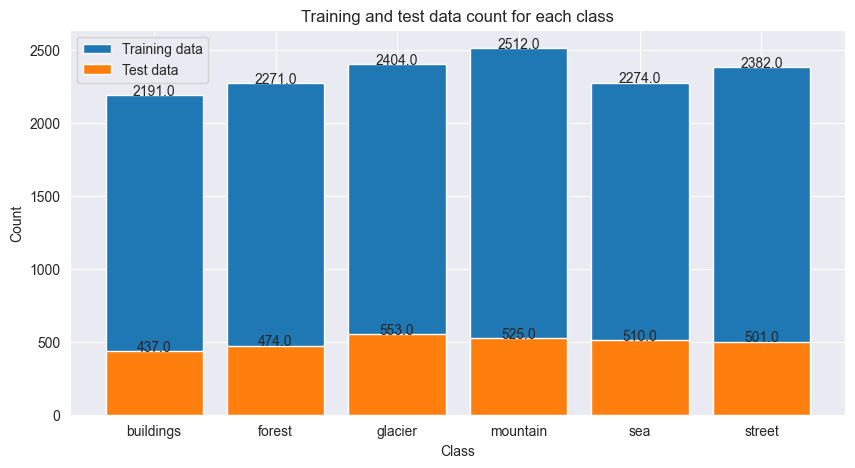

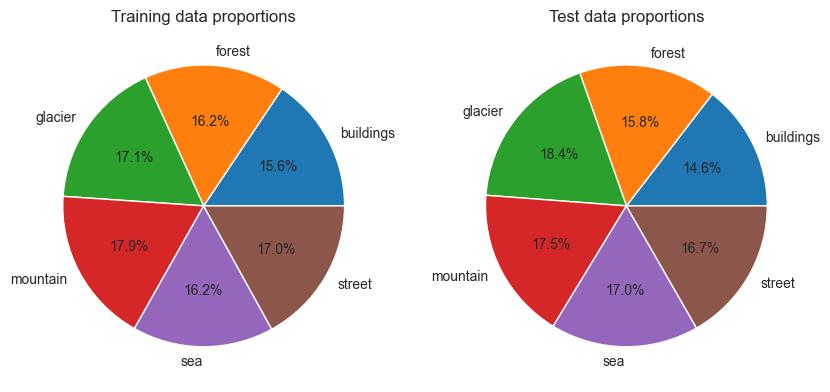

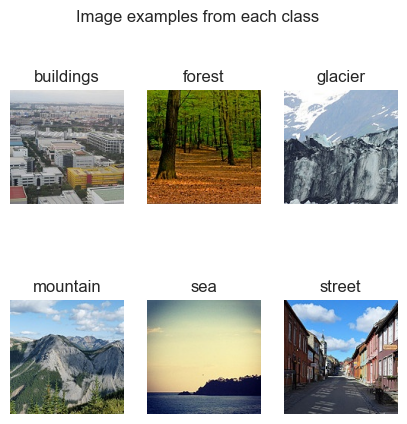

In [ ]:
# Checking the dimensions of the data
print(f"The training data contains {len(train_images)} images with the dimensions {train_images[0].shape} pixels")
print(f"The test data contains {len(test_images)} images with the dimensions {test_images[0].shape} pixels")

# Showing training and test data count for each class
sns.set_style("darkgrid")
plt.figure(figsize=(10, 5))
plt.title("Training and test data count for each class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.bar(classes, [train_labels[:, i].sum() for i in range(len(classes))], label="Training data")
plt.bar(classes, [test_labels[:, i].sum() for i in range(len(classes))], label="Test data")
for i in range(len(classes)):
    plt.text(x=classes[i], y=train_labels[:, i].sum(), s=train_labels[:, i].sum(), ha="center")
    plt.text(x=classes[i], y=test_labels[:, i].sum(), s=test_labels[:, i].sum(), ha="center")
plt.legend()
plt.show()

# Showing the proportion each class has in the training and test data in a pie chart
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training data proportions")
plt.pie([train_labels[:, i].sum() for i in range(len(classes))], labels=classes, autopct="%1.1f%%")
plt.subplot(1, 2, 2)
plt.title("Test data proportions")
plt.pie([test_labels[:, i].sum() for i in range(len(classes))], labels=classes, autopct="%1.1f%%")
plt.show()

# Showing 5 random images from each class
plt.figure(figsize=(5, 5))
plt.suptitle("Image examples from each class")
for i in range(len(classes)):
    plt.subplot(2, 3, i + 1)
    plt.title(classes[i])
    plt.axis("off")
    plt.imshow(train_images[np.random.choice(np.where(train_labels[:, i] == 1)[0])])
plt.show()

---
## Building the model

Each Keras model is created using either the `Sequential` class, which is a linear stack of layers, or the Model functional class, which is more customizable. We're going to import Keras, obviously, but then also specifically the Sequential model type, `dense` layers, `dropout`, and `flatten` (to flatten the data before passing through the final, regular dense layer). Finally, we're using a convolutional neural network, so we're going to use `Conv2D` and `MaxPooling2D` for that.  Later in the code we train the model by defining a function with `batch_size`, `epochs` and `log_freq=10`.  At the end we fit the model and output `history`.

In this a simple module, we coded a function to creats layers. Its structed this way to make it easier to add new layers and to test new approaches. Later in the code we train the model by defining a function with `batch_size`, `epochs` and `log_freq=10`.  At the end we fit the model and output `history`.

### Plain classification model

This code defines a configuration for a machine learning model using the WandB library, which allows for optimization of the model's hyperparameters. The configuration specifies that the 'val_acc' metric should be maximized, and defines a list of possible values for the number of epochs, batch size, dropout rate and optimizer to use.

The function fit.model, which takes in the model, number of epochs, batch size, and training and test data, and returns the training history

In [ ]:
# WandB configuration for the models
sweep_config = {
        'method': 'bayes',
        'metric': {
                'name': 'val_acc',
                'goal': 'maximize'
        },
        'parameters': {
                'epochs': {
                        'value': 20
                },
                'batch_size': {
                        'values': [32, 64, 128]
                },
                'dropout': {
                        'values': [0.4, 0.5, 0.6]
                },
                'optimizer': {
                        'values': ['adam', 'rmsprop']
                },
                'learning_rate': {
                        'values': [0.001, 0.002, 0.0005]
                }
        }
}

In [ ]:
# Importing the necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# model builder
def build_model(dropout, optimizer, lr, layers=[32, 64, 128, 128], input_shape=(150, 150, 3)):
    tf.keras.backend.clear_session()
    gc.collect()
    model = Sequential()

    for i, layer in enumerate(layers):
        if i == 0:
            model.add(Conv2D(layer, (3, 3), activation="relu", input_shape=input_shape))
            model.add(MaxPooling2D((2, 2)))
        else:
            model.add(Conv2D(layer, (3, 3), activation="relu"))
            model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(len(classes), activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer=get_optimizer(lr, optimizer), metrics=["accuracy"])

    return model

def fit_model(model, epochs, batch_size, WandB_run=False, log_freq=10, train_images=train_images, train_labels=train_labels, test_images=test_images, test_labels=test_labels):
    if WandB_run:
        history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels), verbose=0, callbacks=[WandbMetricsLogger(log_freq=log_freq)])
    else:
        history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels), verbose=0)
    return history

#### WandB run for auto logging

In [ ]:
def sweep_train(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(project="Exam", entity="dis21a1_ws22-21_gruppe10", config=config_defaults):  # this gets over-written in the Sweep

        # Specify the other hyperparameters to the configuration, if any
        wandb.config.architecture_name = "Plain CNN"
        wandb.config.dataset_name = "data"

        # initialize model
        model = build_model(
            wandb.config.dropout,
            wandb.config.optimizer,
            wandb.config.learning_rate
        )

        fit_model(
            model,
            wandb.config.epochs,
            wandb.config.batch_size,
            True
        )

# sweep_id = wandb.sweep(sweep_config, project="Exam", entity="dis21a1_ws22-21_gruppe10")
# wandb.agent(sweep_id, function=sweep_train, count=10)

#### Manual run for evaluation

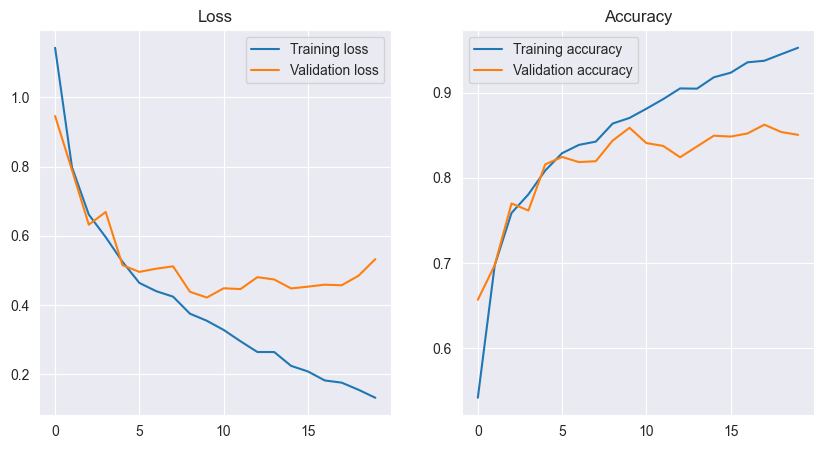

94/94 [==============================] - 1s 10ms/step - loss: 0.5328 - accuracy: 0.8507


In [ ]:
# model training
plain_model = build_model(0.5, "adam", 0.0005)
# plotting the loss and accuracy of the model
plot_loss_accuracy(fit_model(plain_model, 20, 128))
# Evaluating the model
plain_test_loss, plain_test_accuracy = plain_model.evaluate(test_images, test_labels)

In [ ]:
import pandas as pd
import tabulate

# Showing the WandB results in a table
# Reading in csv file
df = pd.read_csv("./wandb_export_Plain_CNN.csv")
# Sorting the results by validation accuracy
df = df.sort_values(by="epoch/val_accuracy", ascending=False)
# Showing the results in a fancy grid
print(tabulate.tabulate(df, headers="keys", tablefmt="fancy_grid", showindex=False))

╒═══════════╤══════════════╤═══════════╤═════════════════╤═════════════╤══════════════════╤════════════════════╤═══════════════════════╤══════════════╤══════════════════╤═══════════════════════╤══════════════╤══════════════════════╤══════════════════╕
│   Runtime │   batch_size │   dropout │   learning_rate │ optimizer   │   batch/accuracy │   batch/batch_step │   batch/learning_rate │   batch/loss │   epoch/accuracy │   epoch/learning_rate │   epoch/loss │   epoch/val_accuracy │   epoch/val_loss │
╞═══════════╪══════════════╪═══════════╪═════════════════╪═════════════╪══════════════════╪════════════════════╪═══════════════════════╪══════════════╪══════════════════╪═══════════════════════╪══════════════╪══════════════════════╪══════════════════╡
│       233 │           64 │       0.5 │          0.0005 │ adam        │         0.961123 │               4390 │                0.0005 │    0.105414  │         0.961094 │                0.0005 │    0.105133  │             0.87     │         0.4

---
### Resnet18 Model

**ResNet**, short for ***Residual Network*** is a specific type of neural network that was introduced in 2015 by *Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun* in their paper 	[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385). **ResNet** itself is an artificial neural network that introduced a so-called “identity shortcut connection,” which allows the model to skip one or more layers. This approach makes it possible to train the network on thousands of layers without affecting performance. It’s become one of the most popular architectures for various computer vision tasks.

- Won 1st place in the ILSVRC 2015 classification competition with a top-5 error rate of 3.57% (An ensemble model)
- Won the 1st place in ILSVRC and COCO 2015 competition in ImageNet Detection, ImageNet localization, Coco detection and Coco segmentation.
- Replacing VGG-16 layers in Faster R-CNN with ResNet-101. They observed relative improvements of 28%
- Efficiently trained networks with 100 layers and 1000 layers also.



The code imports the `ResNet18` model and uses it to build a new model by adding a flatten layer and two dense layers. Furthermore the model is then compiled with `categorical_crossentropy` as loss function, `rmsprop` as optimizer, and `acc` as metrics.



In [ ]:
# Importing the necessary libraries
from classification_models.keras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

# ResNet18 model builder
def build_Resnet_model(optimizer, lr):
    tf.keras.backend.clear_session()
    gc.collect()
    model = Sequential()

    base = ResNet18(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    model.add(base)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(len(classes), activation='sigmoid'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer = get_optimizer(lr, optimizer),
        metrics=['accuracy']
        )

    return model

def fit_Resnet_model(model, epochs, batch_size, WandB_run=False, log_freq=10, train_images=train_images, train_labels=train_labels, test_images=test_images, test_labels=test_labels):
    if WandB_run:
        history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels), verbose=0, callbacks=[WandbMetricsLogger(log_freq=log_freq)])
    else:
        history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels), verbose=0)
    return history

#### WandB run for auto logging

In [ ]:
def sweep_train_ResNet(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(project="Exam", entity="dis21a1_ws22-21_gruppe10", config=config_defaults):  # this gets over-written in the Sweep

        # Specify the other hyperparameters to the configuration, if any
        wandb.config.architecture_name = "ResNet18"
        wandb.config.dataset_name = "data"

        # initialize model
        model = build_Resnet_model(
            wandb.config.optimizer,
            wandb.config.learning_rate
        )

        fit_Resnet_model(
            model,
            wandb.config.epochs,
            wandb.config.batch_size,
            True
        )

# sweep_id = wandb.sweep(sweep_config, project="Exam", entity="dis21a1_ws22-21_gruppe10")
# wandb.agent(sweep_id, function=sweep_train_ResNet, count=10)

#### Manual run for evaluation

In [ ]:
# Showing the WandB results in a table
# Reading in csv file
df = pd.read_csv("./wandb_export_Resnet18.csv")
# Sorting the results by validation accuracy
df = df.sort_values(by="epoch/val_acc", ascending=False)
# Showing the results in a fancy grid
print(tabulate.tabulate(df, headers="keys", tablefmt="fancy_grid", showindex=False))

╒═══════════╤══════════════╤═════════════════╤═════════════╤══════════╤═════════════╤════════════════════╤═══════════════════════╤══════════════╤═════════════╤═══════════════════════╤══════════════╤═════════════════╤══════════════════╕
│   Runtime │   batch_size │   learning_rate │ optimizer   │   epochs │   batch/acc │   batch/batch_step │   batch/learning_rate │   batch/loss │   epoch/acc │   epoch/learning_rate │   epoch/loss │   epoch/val_acc │   epoch/val_loss │
╞═══════════╪══════════════╪═════════════════╪═════════════╪══════════╪═════════════╪════════════════════╪═══════════════════════╪══════════════╪═════════════╪═══════════════════════╪══════════════╪═════════════════╪══════════════════╡
│       499 │          128 │          0.0005 │ adam        │       20 │    0.992884 │               2190 │                0.0005 │    0.0211411 │    0.993231 │                0.0005 │    0.0203206 │        0.908    │         0.465048 │
├───────────┼──────────────┼─────────────────┼──────────

---
### Classification model with data augmentation

This is the same modul, it only differentiate in the way that we use the augmented version of the data


The code is creating a function called `build_model` which takes in three parameters: 
- layers 
- dropout
- input_shape. 

The function creates a new `Sequential` model, then adds several `Conv2D` and `MaxPooling2D` layers to the model based on the input layers parameter. Afterwards, it creates the model and trains it.

In [ ]:
def fit_augmented_model(model, epochs, batch_size, WandB_run=False, log_freq=10, train_generator=train_generator, test_generator=test_generator):
    if WandB_run:
        history = model.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=test_generator, verbose=0, callbacks=[WandbMetricsLogger(log_freq=log_freq)])
    else:
        history = model.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=test_generator, verbose=0)
    return history

#### WandB run for auto logging

In [ ]:
def sweep_train_augmented(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(project="Exam", entity="dis21a1_ws22-21_gruppe10", config=config_defaults):  # this gets over-written in the Sweep

        # Specify the other hyperparameters to the configuration, if any
        wandb.config.architecture_name = "Augmented_CNN"
        wandb.config.dataset_name = "data"

        # initialize model
        model = build_model(
            wandb.config.dropout,
            wandb.config.optimizer,
            wandb.config.learning_rate
        )

        fit_augmented_model(
            model,
            wandb.config.epochs,
            wandb.config.batch_size,
            True
        )

# sweep_id = wandb.sweep(sweep_config, project="Exam", entity="dis21a1_ws22-21_gruppe10")
# wandb.agent(sweep_id, function=sweep_train_augmented, count=10)

#### Manual run for evaluation

In [ ]:
# model training
augmented_model = build_model(0.5, "adam", 0.0005)
# plotting the loss and accuracy of the model
plot_loss_accuracy(fit_augmented_model(augmented_model, 20, 128))
# Evaluating the model
augmented_test_loss, augmented_test_accuracy = augmented_model.evaluate(test_images, test_labels)

In [ ]:
# Showing the WandB results in a table
# Reading in csv file
df = pd.read_csv("./wandb_export_Augmented.csv")
# Sorting the results by validation accuracy
df = df.sort_values(by="epoch/val_accuracy", ascending=False)
# Showing the results in a fancy grid
print(tabulate.tabulate(df, headers="keys", tablefmt="fancy_grid", showindex=False))

╒═══════════╤══════════════╤═══════════╤═════════════════╤═════════════╤══════════════════╤═══════════════════════╤══════════════╤══════════════════╤═══════════════════════╤══════════════╤══════════════════════╤══════════════════╕
│   Runtime │   batch_size │   dropout │   learning_rate │ optimizer   │   batch/accuracy │   batch/learning_rate │   batch/loss │   epoch/accuracy │   epoch/learning_rate │   epoch/loss │   epoch/val_accuracy │   epoch/val_loss │
╞═══════════╪══════════════╪═══════════╪═════════════════╪═════════════╪══════════════════╪═══════════════════════╪══════════════╪══════════════════╪═══════════════════════╪══════════════╪══════════════════════╪══════════════════╡
│       795 │           32 │       0.4 │          0.0005 │ adam        │         0.838233 │                0.0005 │     0.448474 │         0.83825  │                0.0005 │     0.448306 │             0.850333 │         0.451639 │
├───────────┼──────────────┼───────────┼─────────────────┼─────────────┼────

---
## Error Analysis

The dataset implementation is flawed because the images arent well implemented. Some images are poorly represented like the mountain and a glacier as an example. Error Analysis takes an example of a few images by visualizing and plotting them.

The validated data from each data is run again to compare the predicted labels with the original labels. The mislabeled images are viewed.

### Why our model cant achieve 100 percent
The reason why our model cant go beyond 90 percent is because the images, which were given to us as training data are not clean with the labels. To achieve a higher percentage accuracy, we would have to do preprocessing on the images. We have already tried this by rotating the images etc. and by reusing the generators, but this has obviously not been enough.


### Confusion Matrix
Finally, the code creates a confusion matrix and displays it in a heatmap. The confusion matrix shows the number of times each label was predicted as each other label. The x-axis represents the predicted labels and the y-axis represents the true labels.

### Hyperparameter tuning on best model

In [ ]:
# Vector of probabilities
predictions = plain_model.predict(test_images)
# We take the highest probability
pred_labels = np.argmax(predictions, axis = 1)

94/94 [==============================] - 1s 7ms/step


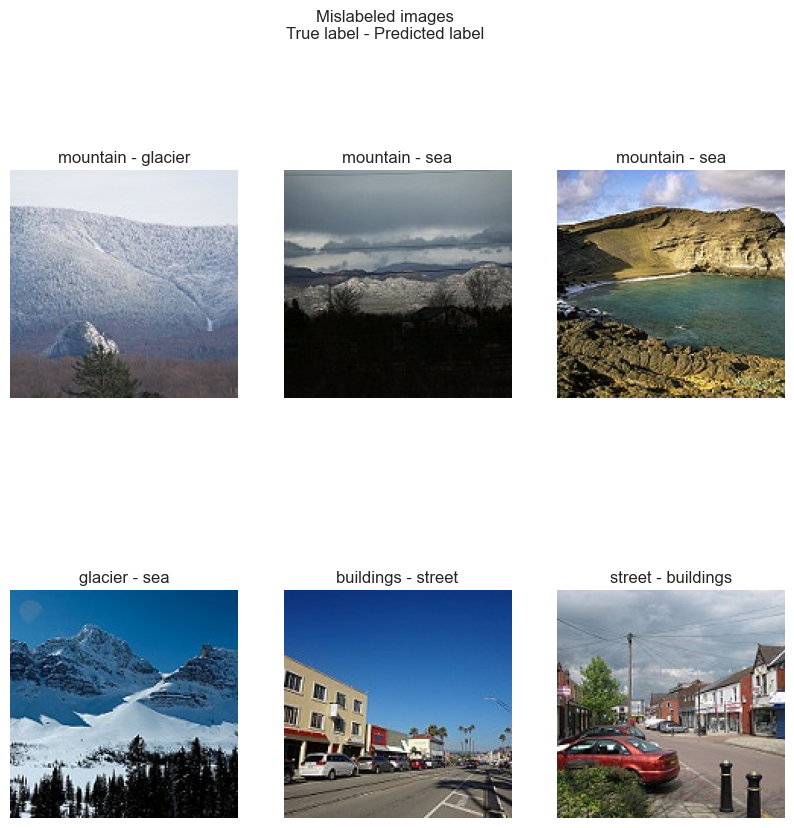

In [ ]:
# Show the mislabeled images along with their true and predicted labels
plt.figure(figsize=(10, 10))
plt.suptitle("Mislabeled images\nTrue label - Predicted label")
for i, mislabeled in enumerate(np.where(pred_labels != test_labels.argmax(axis=1))[0][random.sample(range(0, len(np.where(pred_labels != test_labels.argmax(axis=1))[0])), 6)]):
    plt.subplot(2, 3, i + 1)
    plt.title(f"{classes[test_labels.argmax(axis=1)[mislabeled]]} - {classes[pred_labels[mislabeled]]}")
    plt.axis("off")
    plt.imshow(test_images[mislabeled])
plt.show()

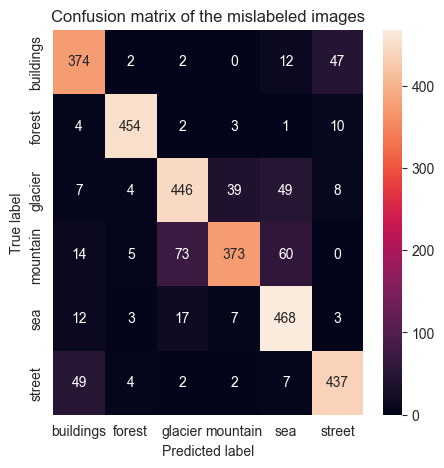

In [ ]:
# Show a confusion matrix of the mislabeled images
confusion_matrix = tf.math.confusion_matrix(labels=test_labels.argmax(axis=1), predictions=pred_labels)
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.title("Confusion matrix of the mislabeled images")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

---
## VGG16 Model with feature extraction

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input


def feature_extraction(test_images=test_images, train_images=train_images):
    tf.keras.backend.clear_session()
    gc.collect()
    # Feature extraction with VGG16
    fe_model = VGG16(weights='imagenet', include_top=False)
    fe_model = Model(inputs=fe_model.inputs, outputs=fe_model.layers[-5].output)
    train_features = fe_model.predict(train_images)
    test_features = fe_model.predict(test_images)

    # Preparing layers for the new model
    model = VGG16(weights='imagenet', include_top=False)

    input_shape = model.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
    layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer
    # https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

    x = layer_input
    for layer in model.layers[-4::1]:
        x = layer(x)
        
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(100,activation='relu')(x)
    x = Dense(6,activation='softmax')(x)

    return train_features, test_features, layer_input, x

In [ ]:
def build_VGG16_model(optimizer, lr, layer_input, x):
    model = Model(layer_input, x)
    model.compile(optimizer=get_optimizer(lr, optimizer), loss = 'categorical_crossentropy', metrics=['accuracy'])
    return model

def fit_VGG16_model(train_features, model, epochs, batch_size, WandB_run = False, log_freq = 10):
    if WandB_run:
        history = model.fit(train_features, train_labels, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=0, callbacks=[WandbMetricsLogger(log_freq=log_freq)])
    else:
        history = model.fit(train_features, train_labels, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=0)
    return history

#### WandB run for auto logging

In [ ]:
def sweep_train_VGG16(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(project="Exam", entity="dis21a1_ws22-21_gruppe10", config=config_defaults):  # this gets over-written in the Sweep

        # Specify the other hyperparameters to the configuration, if any
        wandb.config.architecture_name = "VGG16"
        wandb.config.dataset_name = "data"
        
        # Feature extraction with VGG16
        train_features, test_features, layer_input, x = feature_extraction()
        # initialize model
        model = build_VGG16_model(
            wandb.config.optimizer,
            wandb.config.learning_rate,
            layer_input,
            x
        )

        fit_VGG16_model(
            train_features,
            model,
            wandb.config.epochs,
            wandb.config.batch_size,
            True
        )

# sweep_id = wandb.sweep(sweep_config, project="Exam", entity="dis21a1_ws22-21_gruppe10")
# wandb.agent(sweep_id, function=sweep_train_VGG16, count=10)

#### Manual run for evaluation

94/94 [==============================] - 6s 64ms/step


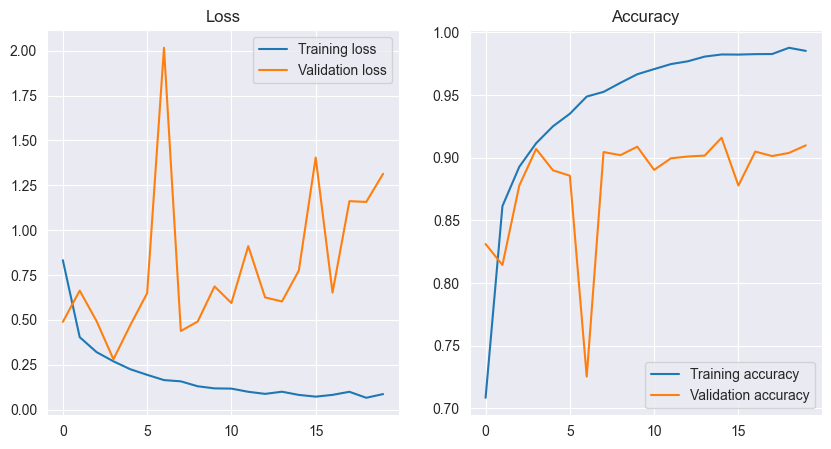

94/94 [==============================] - 1s 10ms/step - loss: 1.4180 - accuracy: 0.9033


In [ ]:
# feature extraction
train_features, test_features, layer_input, x = feature_extraction()
# model training
VGG16_model = build_VGG16_model("rmsprop", 0.0005, layer_input, x)
# plotting the loss and accuracy
plot_loss_accuracy(fit_VGG16_model(train_features, VGG16_model, 20, 64))
# evaluating the model
VGG16_test_loss, VGG16_test_accuracy = VGG16_model.evaluate(test_features, test_labels)

In [ ]:
# Showing the WandB results in a table
# Reading in csv file
df = pd.read_csv("./wandb_export_VGG16.csv")
# Sorting the results by validation accuracy
df = df.sort_values(by="epoch/val_accuracy", ascending=False)
# Showing the results in a fancy grid
print(tabulate.tabulate(df, headers="keys", tablefmt="fancy_grid", showindex=False))

╒═══════════╤══════════════╤═════════════════╤═════════════╤══════════════════╤════════════════════╤═══════════════════════╤══════════════╤══════════════════╤═══════════════════════╤══════════════╤══════════════════════╤══════════════════╕
│   Runtime │   batch_size │   learning_rate │ optimizer   │   batch/accuracy │   batch/batch_step │   batch/learning_rate │   batch/loss │   epoch/accuracy │   epoch/learning_rate │   epoch/loss │   epoch/val_accuracy │   epoch/val_loss │
╞═══════════╪══════════════╪═════════════════╪═════════════╪══════════════════╪════════════════════╪═══════════════════════╪══════════════╪══════════════════╪═══════════════════════╪══════════════╪══════════════════════╪══════════════════╡
│       131 │          128 │          0.0005 │ rmsprop     │         0.9864   │               1790 │                0.0005 │    0.0572111 │         0.985838 │                0.0005 │    0.0597801 │             0.900962 │         0.852671 │
├───────────┼──────────────┼────────────

---
## Final run on finished model

In [ ]:
from sklearn.metrics import accuracy_score

validation_files = [photo for photo in os.listdir(data_valpath) if photo.endswith(".jpg")]
validation_images = []
for photo in validation_files:
    img = Image.open(os.path.join(data_valpath, photo))
    img = img.resize((150, 150))
    validation_images.append(img)

validation_images = image_normalization(validation_images)

train_features, test_features, layer_input, x = feature_extraction(validation_images)

predictions = VGG16_model.predict(test_features)
pred_labels = np.argmax(predictions, axis = 1)
# map the labels to the classes
pred_labels = [classes[i] for i in pred_labels]

229/229 [==============================] - 2s 7ms/step


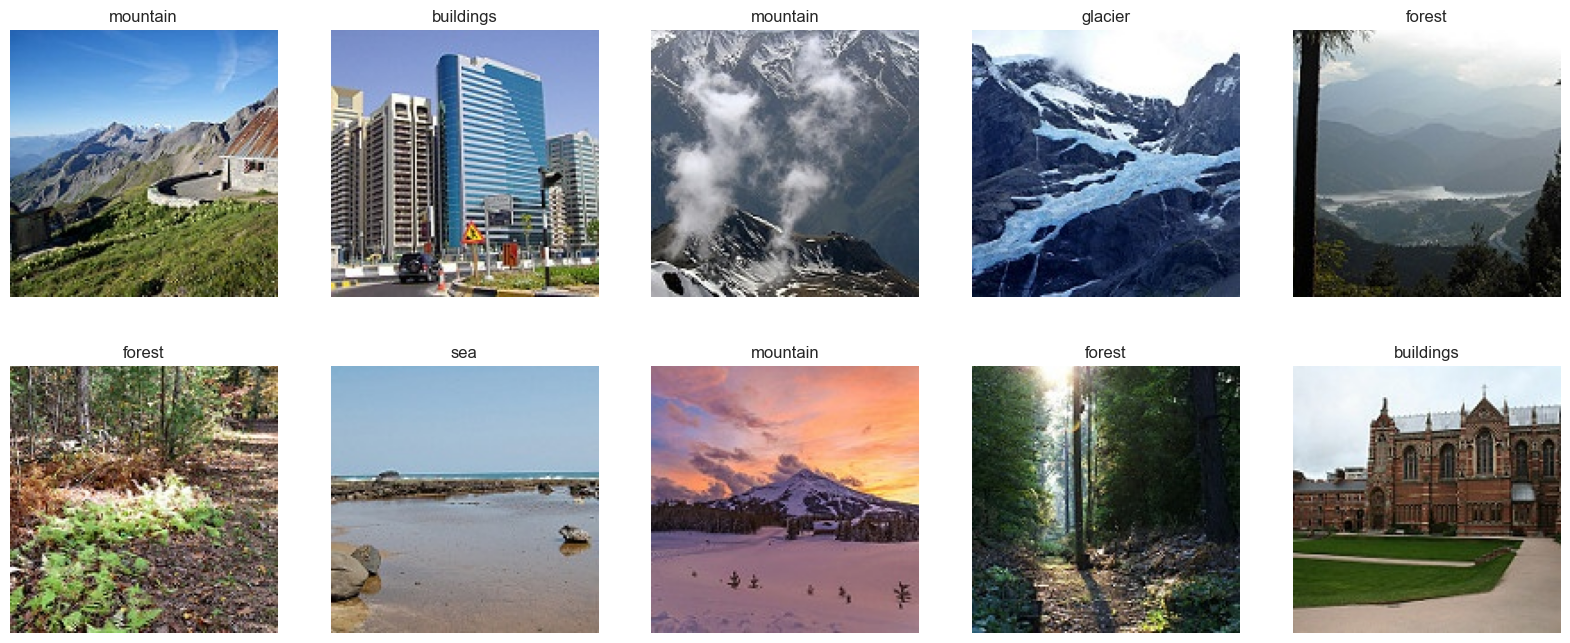

In [ ]:
# plot 10 random images with their predicted labels
nrows = 2
ncols = 5
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
for i in range(ncols * nrows):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 
    random_index = np.random.randint(0, len(validation_images))
    plt.imshow(validation_images[random_index])
    plt.title(pred_labels[random_index])
plt.show()